# Classification — ResNet-50
**Author:** Sayed Pedram Haeri Boroujeni  
**Position:** PhD Student, Clemson University  
**Affiliation:** Department of Computer Science  
**Email:** shaerib@g.clemson.edu  
**Date Created:** October 10, 2025  

##### 1. Importing Required Libraries

In [1]:
import argparse, os, random, time, math, csv, shutil, glob
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet50_Weights
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

##### 2. Checking GPU Availability

In [2]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Device Name: {torch.cuda.get_device_name()}")
else:
    print("CUDA is not available on this system.")

CUDA Available: True
CUDA Version: 12.6
Number of GPUs: 1
Device Name: NVIDIA RTX A5000


##### 3. Reproducibility

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

set_seed(1)

##### 4. Configuration

In [4]:
data_dir = "ADD YOUR PATH HERE"  

use_kfold = False      # 🔁 Set True for K-Fold, False for fixed split
num_folds = 5          # K value if K-Fold is used
num_epochs = 30
batch_size = 16
learning_rate = 1e-4
momentum = 0.9

##### 5. Dataset Preparation

In [5]:
def prepare_dataset(root_dir, img_size=224):
    """
    Prepare dataset for training:
    1. Detect class subfolders (e.g., Fire, no_Fire).
    2. Split each class (60/20/20) into train/val/test while keeping subfolders.
    3. Resize and rename images.
    4. Report per-class counts.
    """
    from collections import defaultdict

    root_dir = Path(root_dir)
    train_dir, val_dir, test_dir = [root_dir / x for x in ["train", "val", "test"]]
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tiff", "*.webp"]

    def all_images_in(folder):
        imgs = []
        for ext in exts:
            imgs.extend(Path(folder).rglob(ext))
        return imgs

    # Detect original class folders
    class_folders = [
        f for f in root_dir.iterdir()
        if f.is_dir() and f.name.lower() not in ["train", "val", "test"]
    ]
    if not class_folders:
        raise RuntimeError("No class subfolders found (expected 'Fire', 'no_Fire').")

    # Create split dirs and subdirs
    for split in ["train", "val", "test"]:
        for cls in class_folders:
            (root_dir / split / cls.name).mkdir(parents=True, exist_ok=True)

    counts = defaultdict(lambda: {"train": 0, "val": 0, "test": 0})

    print("⚙️ Splitting dataset by class into train (60%), val (20%), test (20%)...")
    for cls_folder in class_folders:
        cls_name = cls_folder.name
        images = []
        for ext in exts:
            images.extend(cls_folder.rglob(ext))
        images = [p for p in images if p.is_file()]
        if not images:
            print(f"⚠️ No images found in {cls_name}")
            continue

        # Split 60/20/20 for this class
        train_files, temp_files = train_test_split(images, test_size=0.4, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
        splits = {"train": train_files, "val": val_files, "test": test_files}

        for split, files in splits.items():
            out_dir = root_dir / split / cls_name
            for i, file_path in enumerate(tqdm(files, desc=f"{cls_name} → {split}", ncols=90)):
                try:
                    img = Image.open(file_path).convert("RGB")
                    img = img.resize((img_size, img_size))
                    new_name = f"{i+1}.jpg"
                    out_path = out_dir / new_name
                    img.save(out_path, "JPEG", quality=95)
                except Exception as e:
                    print(f"❌ Error processing {file_path}: {e}")
            counts[cls_name][split] += len(files)

    # Print summary
    print("\n✅ Dataset split completed successfully with class subfolders:")
    for split in ["train", "val", "test"]:
        total = sum(counts[c][split] for c in counts)
        print(f"  {split.capitalize()}: {total} images")
        for cls in counts:
            print(f"    {cls}: {counts[cls][split]} images")

    return counts

#For Testing
#prepare_dataset("C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/Fire")

##### 6. Data Loading & Transformations

In [6]:
# ImageNet normalization values for pretrained ResNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} images")
print(f"Validation: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")

Train: 599 images
Validation: 200 images
Test: 200 images


##### 7. ResNet-50 Model Initialization

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

# Initialize pretrained ResNet-50
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(momentum, 0.999))

print("✅ ResNet-50 initialized successfully")
print(f"Device: {device}")
print(f"Classes: {train_dataset.classes}")
print(f"Learning rate: {learning_rate}, Momentum (β₁): {momentum}")

✅ ResNet-50 initialized successfully
Device: cuda
Classes: ['fire_images', 'non_fire_images']
Learning rate: 0.0001, Momentum (β₁): 0.9


##### 8. ResNet-50 Training & Validation Loop

In [8]:
##### 8. ResNet-50 Training & Optional K-Fold Cross-Validation (stores histories) #####

def train_model(model, criterion, optimizer, train_loader, val_loader,
                num_epochs, device='cuda', fold=None):
    """Training loop with validation, best model saving, and metric recording."""
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", ncols=90):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        # ---- Validation ----
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())

        print(f"[{epoch:02d}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            model_name = f"best_resnet50_fire_fold{fold}.pth" if fold else "best_resnet50_fire.pth"
            torch.save(model.state_dict(), model_name)

    print(f"\n✅ Training completed. Best Val Accuracy: {best_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs, best_acc


# ============================================================
# 🔁 K-Fold Cross-Validation or Fixed Split
# ============================================================

if use_kfold:
    print(f"🔁 Running {num_folds}-Fold Cross-Validation …\n")

    full_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
    all_labels = [label for _, label in full_dataset.samples]
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_results = []
    fold_histories = {}   # 📊 store loss/accuracy for each fold

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels)):
        print(f"\n===== Fold {fold+1}/{num_folds} =====")

        train_subset = Subset(full_dataset, train_idx)
        val_subset   = Subset(full_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False, num_workers=2)

        # Re-initialize model each fold
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, len(full_dataset.classes))
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(momentum, 0.999))

        tr_loss, vl_loss, tr_acc, vl_acc, best_acc = train_model(
            model, criterion, optimizer, train_loader, val_loader,
            num_epochs=num_epochs, device=device, fold=fold+1
        )

        fold_results.append(best_acc.item())

        # Store curves for this fold
        fold_histories[fold+1] = {
            "train_losses": tr_loss,
            "val_losses": vl_loss,
            "train_accs": tr_acc,
            "val_accs": vl_acc,
            "best_acc": best_acc.item()
        }

    print("\n✅ Cross-validation complete.")
    print(f"Average Val Accuracy: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

else:
    print("➡️ Using fixed train/val/test split.\n")

    tr_loss, vl_loss, tr_acc, vl_acc, best_acc = train_model(
        model, criterion, optimizer, train_loader, val_loader,
        num_epochs=num_epochs, device=device
    )

    # ✅ Store results for plotting later
    fold_histories = {
        0: {
            "train_losses": tr_loss,
            "val_losses": vl_loss,
            "train_accs": tr_acc,
            "val_accs": vl_acc,
            "best_acc": best_acc.item()
        }
    }

    print(f"✅ Fixed-split training complete. Best Val Accuracy: {best_acc:.4f}")

➡️ Using fixed train/val/test split.



Epoch 1/30: 100%|█████████████████████████████████████████| 38/38 [00:11<00:00,  3.44it/s]


[01/30] Train Loss: 0.1772 | Train Acc: 0.9316 | Val Loss: 0.0316 | Val Acc: 0.9900


Epoch 2/30: 100%|█████████████████████████████████████████| 38/38 [00:09<00:00,  3.93it/s]


[02/30] Train Loss: 0.0511 | Train Acc: 0.9816 | Val Loss: 0.0081 | Val Acc: 1.0000


Epoch 3/30: 100%|█████████████████████████████████████████| 38/38 [00:09<00:00,  3.96it/s]


[03/30] Train Loss: 0.0314 | Train Acc: 0.9883 | Val Loss: 0.0113 | Val Acc: 0.9950


Epoch 4/30: 100%|█████████████████████████████████████████| 38/38 [00:09<00:00,  3.89it/s]


[04/30] Train Loss: 0.0455 | Train Acc: 0.9833 | Val Loss: 0.1399 | Val Acc: 0.9500


Epoch 5/30: 100%|█████████████████████████████████████████| 38/38 [00:09<00:00,  3.86it/s]


[05/30] Train Loss: 0.0835 | Train Acc: 0.9766 | Val Loss: 0.0340 | Val Acc: 0.9950


Epoch 6/30: 100%|█████████████████████████████████████████| 38/38 [00:09<00:00,  3.83it/s]


[06/30] Train Loss: 0.0338 | Train Acc: 0.9900 | Val Loss: 0.0230 | Val Acc: 0.9950


Epoch 7/30: 100%|█████████████████████████████████████████| 38/38 [00:10<00:00,  3.75it/s]


[07/30] Train Loss: 0.0549 | Train Acc: 0.9800 | Val Loss: 0.0281 | Val Acc: 0.9900


Epoch 8/30: 100%|█████████████████████████████████████████| 38/38 [00:10<00:00,  3.66it/s]


[08/30] Train Loss: 0.0219 | Train Acc: 0.9933 | Val Loss: 0.0245 | Val Acc: 0.9900


Epoch 9/30: 100%|█████████████████████████████████████████| 38/38 [00:11<00:00,  3.41it/s]


[09/30] Train Loss: 0.0129 | Train Acc: 0.9967 | Val Loss: 0.0158 | Val Acc: 0.9950


Epoch 10/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.58it/s]


[10/30] Train Loss: 0.0181 | Train Acc: 0.9950 | Val Loss: 0.0155 | Val Acc: 0.9950


Epoch 11/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.38it/s]


[11/30] Train Loss: 0.0071 | Train Acc: 1.0000 | Val Loss: 0.0058 | Val Acc: 1.0000


Epoch 12/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.53it/s]


[12/30] Train Loss: 0.0038 | Train Acc: 1.0000 | Val Loss: 0.0048 | Val Acc: 1.0000


Epoch 13/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.57it/s]


[13/30] Train Loss: 0.0023 | Train Acc: 1.0000 | Val Loss: 0.0311 | Val Acc: 0.9900


Epoch 14/30: 100%|████████████████████████████████████████| 38/38 [00:09<00:00,  3.81it/s]


[14/30] Train Loss: 0.0017 | Train Acc: 1.0000 | Val Loss: 0.0377 | Val Acc: 0.9850


Epoch 15/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.76it/s]


[15/30] Train Loss: 0.0032 | Train Acc: 1.0000 | Val Loss: 0.0290 | Val Acc: 0.9900


Epoch 16/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.55it/s]


[16/30] Train Loss: 0.0060 | Train Acc: 0.9983 | Val Loss: 0.0491 | Val Acc: 0.9900


Epoch 17/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.19it/s]


[17/30] Train Loss: 0.0047 | Train Acc: 1.0000 | Val Loss: 0.0104 | Val Acc: 0.9900


Epoch 18/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.30it/s]


[18/30] Train Loss: 0.0049 | Train Acc: 0.9983 | Val Loss: 0.0273 | Val Acc: 0.9900


Epoch 19/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.73it/s]


[19/30] Train Loss: 0.0121 | Train Acc: 0.9967 | Val Loss: 0.0286 | Val Acc: 0.9900


Epoch 20/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.78it/s]


[20/30] Train Loss: 0.0028 | Train Acc: 1.0000 | Val Loss: 0.0077 | Val Acc: 0.9950


Epoch 21/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.56it/s]


[21/30] Train Loss: 0.0218 | Train Acc: 0.9950 | Val Loss: 0.0222 | Val Acc: 0.9900


Epoch 22/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.37it/s]


[22/30] Train Loss: 0.0428 | Train Acc: 0.9900 | Val Loss: 0.0171 | Val Acc: 0.9900


Epoch 23/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.50it/s]


[23/30] Train Loss: 0.0099 | Train Acc: 0.9967 | Val Loss: 0.0102 | Val Acc: 0.9950


Epoch 24/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.38it/s]


[24/30] Train Loss: 0.0053 | Train Acc: 0.9983 | Val Loss: 0.0155 | Val Acc: 0.9950


Epoch 25/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.27it/s]


[25/30] Train Loss: 0.0198 | Train Acc: 0.9950 | Val Loss: 0.0119 | Val Acc: 0.9950


Epoch 26/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.27it/s]


[26/30] Train Loss: 0.0077 | Train Acc: 0.9983 | Val Loss: 0.0361 | Val Acc: 0.9850


Epoch 27/30: 100%|████████████████████████████████████████| 38/38 [00:10<00:00,  3.56it/s]


[27/30] Train Loss: 0.0202 | Train Acc: 0.9983 | Val Loss: 0.0193 | Val Acc: 0.9900


Epoch 28/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.34it/s]


[28/30] Train Loss: 0.0073 | Train Acc: 0.9950 | Val Loss: 0.0123 | Val Acc: 0.9950


Epoch 29/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.27it/s]


[29/30] Train Loss: 0.0099 | Train Acc: 0.9967 | Val Loss: 0.0212 | Val Acc: 0.9950


Epoch 30/30: 100%|████████████████████████████████████████| 38/38 [00:11<00:00,  3.39it/s]


[30/30] Train Loss: 0.0076 | Train Acc: 0.9983 | Val Loss: 0.0305 | Val Acc: 0.9950

✅ Training completed. Best Val Accuracy: 1.0000
✅ Fixed-split training complete. Best Val Accuracy: 1.0000


##### 9. Plot Training Curves

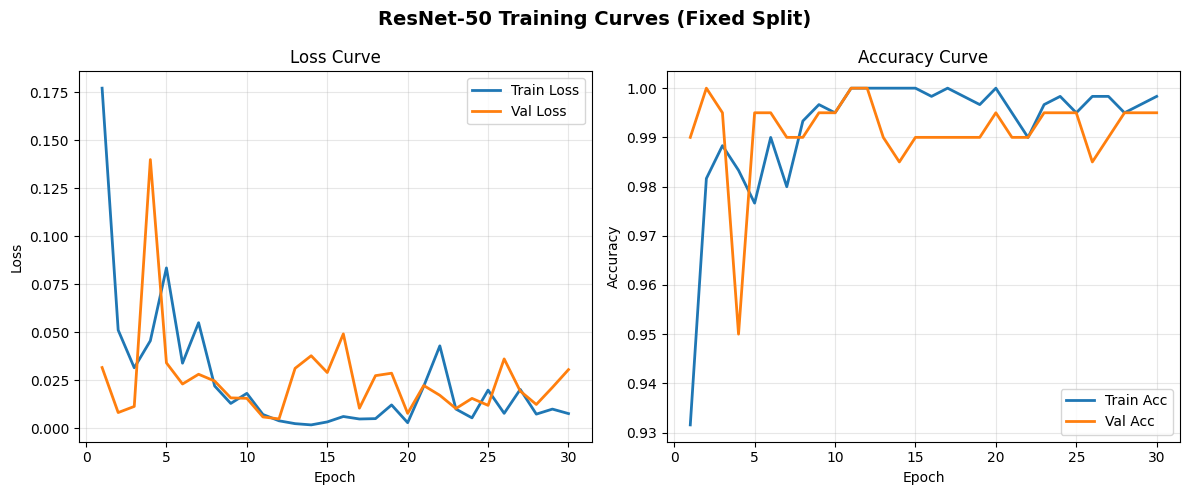

In [10]:
##### 9. Plot Training Curves (Supports K-Fold and Fixed-Split) #####

import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves_kfold(histories, num_folds, title="ResNet-50 K-Fold Training Curves"):
    """Plot all folds together + average trend."""
    plt.figure(figsize=(12,5))

    # --- Loss Curves ---
    plt.subplot(1,2,1)
    for fold, h in histories.items():
        plt.plot(h['train_losses'], alpha=0.5, label=f"Train Fold {fold}")
        plt.plot(h['val_losses'], linestyle='--', alpha=0.5, label=f"Val Fold {fold}")
    # average curves
    max_epochs = min(len(h['train_losses']) for h in histories.values())
    avg_train_loss = np.mean([h['train_losses'][:max_epochs] for h in histories.values()], axis=0)
    avg_val_loss = np.mean([h['val_losses'][:max_epochs] for h in histories.values()], axis=0)
    plt.plot(avg_train_loss, color='blue', linewidth=2.5, label="Avg Train Loss")
    plt.plot(avg_val_loss, color='red', linewidth=2.5, label="Avg Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Across Folds")
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)

    # --- Accuracy Curves ---
    plt.subplot(1,2,2)
    for fold, h in histories.items():
        plt.plot(h['train_accs'], alpha=0.5, label=f"Train Fold {fold}")
        plt.plot(h['val_accs'], linestyle='--', alpha=0.5, label=f"Val Fold {fold}")
    avg_train_acc = np.mean([h['train_accs'][:max_epochs] for h in histories.values()], axis=0)
    avg_val_acc = np.mean([h['val_accs'][:max_epochs] for h in histories.values()], axis=0)
    plt.plot(avg_train_acc, color='blue', linewidth=2.5, label="Avg Train Acc")
    plt.plot(avg_val_acc, color='red', linewidth=2.5, label="Avg Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Across Folds")
    plt.legend(fontsize=8)
    plt.grid(alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


def plot_training_curves_fixed(train_losses, val_losses, train_accs, val_accs,
                               title="ResNet-50 Training Curves (Fixed Split)"):
    """Plot single-run curves."""
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss", linewidth=2)
    plt.plot(epochs, val_losses, label="Val Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(alpha=0.3)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label="Train Acc", linewidth=2)
    plt.plot(epochs, val_accs, label="Val Acc", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


# ============================================================
# Auto-Plot depending on mode
# ============================================================

if use_kfold:
    # If you tracked fold histories manually inside training loop:
    try:
        plot_training_curves_kfold(fold_histories, num_folds)
    except NameError:
        print("⚠️ No 'fold_histories' found.")
else:
    try:
        plot_training_curves_fixed(
            fold_histories[0]['train_losses'],
            fold_histories[0]['val_losses'],
            fold_histories[0]['train_accs'],
            fold_histories[0]['val_accs']
        )
    except NameError:
        print("⚠️ No training history detected.")

##### 10. Evaluation on Test Set

Evaluating: 100%|█████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


✅ Classification Report:
                 precision    recall  f1-score   support

    fire_images     0.9932    0.9669    0.9799       151
non_fire_images     0.9057    0.9796    0.9412        49

       accuracy                         0.9700       200
      macro avg     0.9494    0.9732    0.9605       200
   weighted avg     0.9718    0.9700    0.9704       200



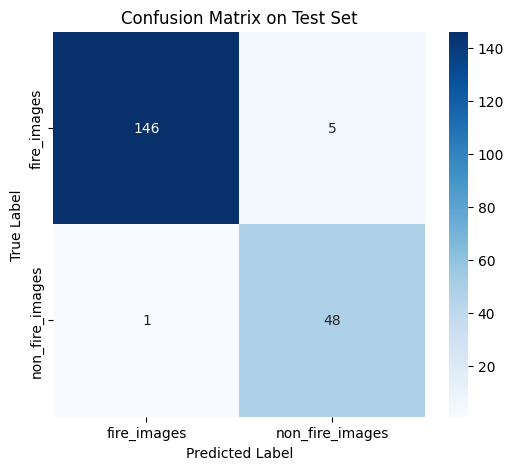

In [11]:
# Reload the best model (from Cell 8)
best_model_path = "best_resnet50_fire.pth" if not use_kfold else "best_resnet50_fire_fold1.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating", ncols=90):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ---- Metrics ----
print("\n✅ Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()

##### 11. Example Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131652..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.2489083].


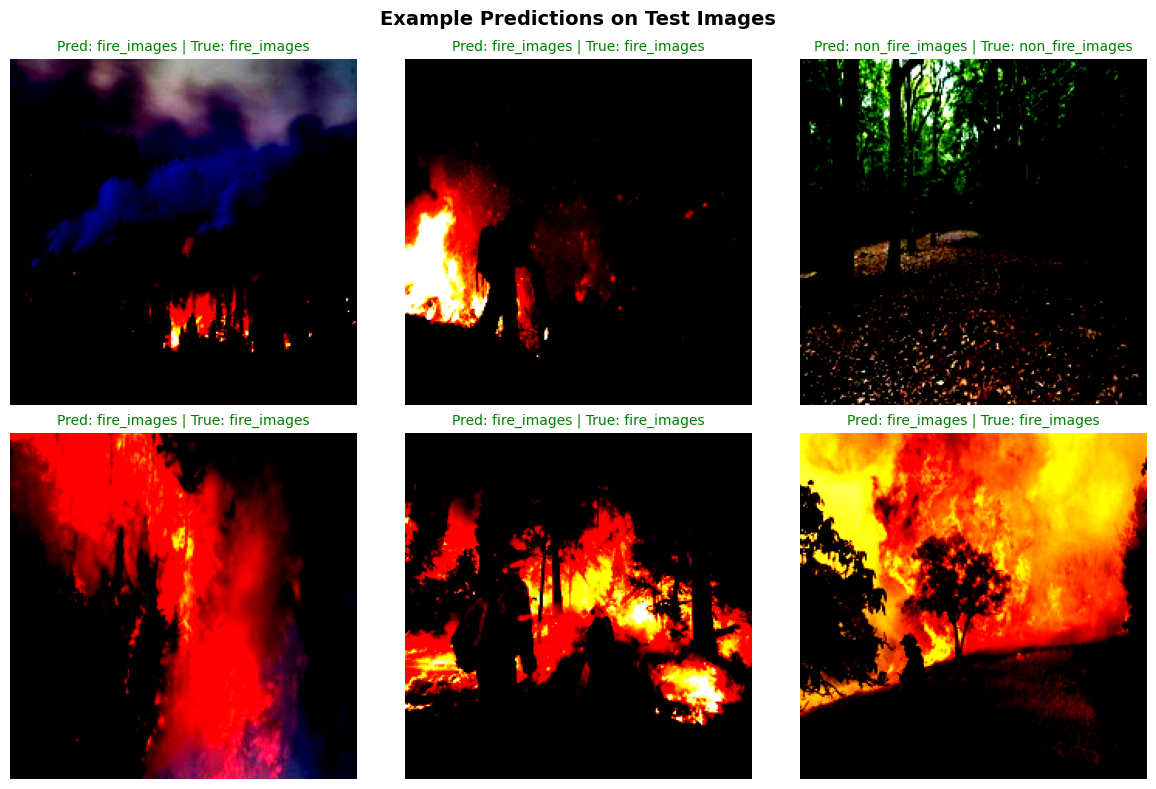

In [12]:
model.eval()

# Pick random indices from test dataset
indices = random.sample(range(len(test_dataset)), 6)

plt.figure(figsize=(12,8))
for i, idx in enumerate(indices):
    img, label = test_dataset[idx]
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
    pred_label = train_dataset.classes[pred.item()]
    true_label = train_dataset.classes[label]
    color = "green" if pred_label == true_label else "red"

    plt.subplot(2,3,i+1)
    plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))
    plt.title(f"Pred: {pred_label} | True: {true_label}", color=color, fontsize=10)
    plt.axis("off")

plt.suptitle("Example Predictions on Test Images", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()